## Problem Description

Given the tabular data we have to predict the "SalePrice" in the validation dataset.

## Dataset

Dataset can be downloaded from here [Predict Future Sales](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

## Approach and accuracy achieved

Since the dataset contained a good amount of features and considerable amount of values in dataset were null, I though it 
right thing to do would be to select limited features based on feature importance. For this I trained a Random forest baseline model and got the importance score of all the features. According to this score features for the final model were selected and Random Forest and lightgbm were tried on the dataset.

Based on importance score I have also tried to replace the null values of the 2 most important features (after age) that were "Coupler_System" and "ProductSize" but the results were not improved.

### Accuracy

    Evaluation parameter: RMSLE (Root mean squared log error) on validation dataset
    
    Random Forest: 0.24668083100145405 (using all features)
    lightgbm: 0.246714 (using features after calculating importance scores)

## Imports

In [3]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import numpy as np
import math
from sklearn import metrics
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt 
from sklearn.ensemble import forest

## Loading the dataset

In [4]:
df_train = pd.read_csv('Train/Train.csv', low_memory=False, parse_dates=['saledate'])
df_valid = pd.read_csv('Valid/Valid.csv', low_memory=False, parse_dates=['saledate'])

## Getting number of unique values and missing values in each column in training dataset

In [5]:
df_train.head().T
#df_valid.head()

#print (df_train.columns)
print('training',df_train.shape)
print('validation', df_valid.shape)

for df_train.col in df_train:
    print (df_train.col, df_train[df_train.col].nunique())
print('#'*100)
print("number of null values")
print('#'*100)
print (df_train.isnull().sum().to_string()) #to know number of nan values for each column
print('#'*100)


training (401125, 53)
validation (11573, 52)
SalesID 401125
SalePrice 899
MachineID 341027
ModelID 5218
datasource 5
auctioneerID 30
YearMade 72
MachineHoursCurrentMeter 15152
UsageBand 3
saledate 3919
fiModelDesc 4999
fiBaseModel 1950
fiSecondaryDesc 175
fiModelSeries 122
fiModelDescriptor 139
ProductSize 6
fiProductClassDesc 74
state 53
ProductGroup 6
ProductGroupDesc 6
Drive_System 4
Enclosure 6
Forks 2
Pad_Type 4
Ride_Control 3
Stick 2
Transmission 8
Turbocharged 2
Blade_Extension 2
Blade_Width 6
Enclosure_Type 3
Engine_Horsepower 2
Hydraulics 12
Pushblock 2
Ripper 4
Scarifier 2
Tip_Control 3
Tire_Size 17
Coupler 3
Coupler_System 2
Grouser_Tracks 2
Hydraulics_Flow 3
Track_Type 2
Undercarriage_Pad_Width 19
Stick_Length 29
Thumb 3
Pattern_Changer 3
Grouser_Type 3
Backhoe_Mounting 2
Blade_Type 10
Travel_Controls 7
Differential_Type 4
Steering_Controls 5
####################################################################################################
number of null values
##########

In [6]:
print (df_train.describe().T)

                             count          mean            std        min  \
SalesID                   401125.0  1.919713e+06  909021.492667  1139246.0   
SalePrice                 401125.0  3.109971e+04   23036.898502     4750.0   
MachineID                 401125.0  1.217903e+06  440991.954249        0.0   
ModelID                   401125.0  6.889703e+03    6221.777842       28.0   
datasource                401125.0  1.346658e+02       8.962237      121.0   
auctioneerID              380989.0  6.556040e+00      16.976779        0.0   
YearMade                  401125.0  1.899157e+03     291.797469     1000.0   
MachineHoursCurrentMeter  142765.0  3.457955e+03   27590.256413        0.0   

                                25%        50%        75%        max  
SalesID                   1418371.0  1639422.0  2242707.0  6333342.0  
SalePrice                   14500.0    24000.0    40000.0   142000.0  
MachineID                 1088697.0  1279490.0  1468067.0  2486330.0  
ModelID      

## Correlation Matrix and Scores 

SalesID                     0.010725
SalePrice                   1.000000
MachineID                  -0.224854
ModelID                    -0.042125
datasource                  0.015122
auctioneerID               -0.046865
YearMade                    0.156453
MachineHoursCurrentMeter    0.013560
dtype: float64


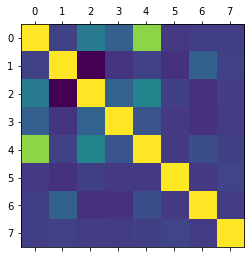

In [7]:
import seaborn as sns
print(df_train.corrwith(df_train['SalePrice'])) 
plt.matshow(df_train.corr())
plt.show()



## Getting number of unique values and missing values in each column in validation dataset


In [8]:
df_valid.head().T
#df_valid.head()


for df_valid.col in df_valid:
    print ((df_valid.col, df_valid[df_valid.col].nunique()))
    
print('#'*100)
print("number of null values")
print('#'*100)
print (df_valid.isnull().sum().to_string()) #to know number of nan values for each column
print ('#'*100)


('SalesID', 11573)
('MachineID', 9681)
('ModelID', 1763)
('datasource', 5)
('auctioneerID', 14)
('YearMade', 55)
('MachineHoursCurrentMeter', 3075)
('UsageBand', 3)
('saledate', 94)
('fiModelDesc', 1731)
('fiBaseModel', 786)
('fiSecondaryDesc', 81)
('fiModelSeries', 59)
('fiModelDescriptor', 73)
('ProductSize', 6)
('fiProductClassDesc', 67)
('state', 48)
('ProductGroup', 6)
('ProductGroupDesc', 6)
('Drive_System', 4)
('Enclosure', 4)
('Forks', 2)
('Pad_Type', 4)
('Ride_Control', 3)
('Stick', 2)
('Transmission', 7)
('Turbocharged', 2)
('Blade_Extension', 2)
('Blade_Width', 6)
('Enclosure_Type', 3)
('Engine_Horsepower', 2)
('Hydraulics', 11)
('Pushblock', 2)
('Ripper', 4)
('Scarifier', 2)
('Tip_Control', 3)
('Tire_Size', 15)
('Coupler', 3)
('Coupler_System', 2)
('Grouser_Tracks', 2)
('Hydraulics_Flow', 3)
('Track_Type', 2)
('Undercarriage_Pad_Width', 16)
('Stick_Length', 21)
('Thumb', 3)
('Pattern_Changer', 3)
('Grouser_Type', 2)
('Backhoe_Mounting', 1)
('Blade_Type', 8)
('Travel_Control

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015AA35E6C48>]],
      dtype=object)

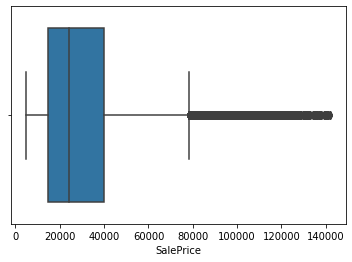

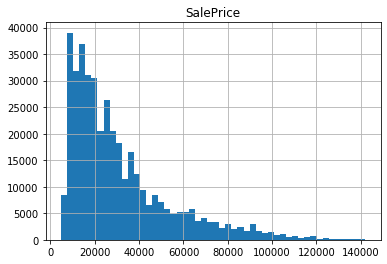

In [9]:
## Looking for Outliers
import seaborn as sns
sns.boxplot(x=df_train['SalePrice'])

df_train.hist(column='SalePrice',bins=50)



### By looking at data we will remove the rows with SalePrice>110000

2846
(397605, 53)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015AA3583308>]],
      dtype=object)

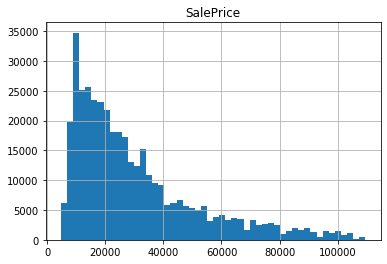

In [10]:
print ((df_train.SalePrice[df_train.SalePrice > 110000]).count())
df_train = df_train[df_train['SalePrice'] < 110000]
print (df_train.shape)

df_train.hist(column='SalePrice',bins=50)

In [11]:
# Converting Sale Price to log scale as evaluation parameter is RMLE
df_train.SalePrice = np.log(df_train.SalePrice)


def add_datepart(df, fldname, drop=True, time=False):
    '''Making more features from the dates features in the Dataset'''
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr = attr + ['Hour', 'Minute', 'Second']
        
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    
    if drop: df.drop(fldname, axis=1, inplace=True)
        
add_datepart(df_train, 'saledate')

# Creating a new feature named age that is age of the Bulldozer at the time of the sale
df_train['age'] = df_train['saleYear'] - df_train['YearMade']

In [12]:
print(df_train.shape)
print(df_train.UsageBand.head().T)

(397605, 66)
0       Low
1       Low
2      High
3      High
4    Medium
Name: UsageBand, dtype: object


In [13]:
# convert string features to categorical

for n,c in df_train.items():
    if is_string_dtype(c): 
        print (n)
        df_train[n] = c.astype('category').cat.as_ordered()
        
#Specify order for variable UsageBand and change to codes
df_train.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_train.UsageBand = df_train.UsageBand.cat.codes



UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [14]:
'''
For continuous variables, it checks whether a column has missing values or not
If the column has missing values, it creates another column called columnname_na, which has 1 for missing and 0 for not missing
Simultaneously, the missing values are replaced with the median of the column
For categorical variables, pandas replaces missing values with -1. So proc_df adds 1 to all the values for categorical variables. Thus, we have 0 for missing while all other values are incremented by 1'''

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1


def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

df, y, nas = proc_df(df_train, 'SalePrice')

In [15]:
#Split the dataset into training and validation sets. Use 12,000 as the validation set for our baseline model
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_train, n_trn) #for using unprocessed data if needed.

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((385605, 67), (12000, 67), (385605,), (12000,))

In [16]:
#Run base model
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

c:\users\ushuk\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09098603417953595, 0.2470126762262637, 0.9820079494844172, 0.8877450123421958]


In [17]:
#Use the feature importance to find the most important ones
feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
37,Coupler_System,0.202387
64,age,0.163148
13,ProductSize,0.143216
14,fiProductClassDesc,0.129971
2,ModelID,0.075867
5,YearMade,0.052569
10,fiSecondaryDesc,0.031023
63,saleElapsed,0.027935
8,fiModelDesc,0.027013
0,SalesID,0.020556


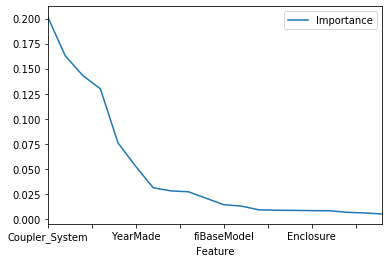

In [18]:
feature_importance.head(20).plot('Feature', 'Importance')

In [19]:
for i in [0.0001, 0.0005, 0.0007, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features = feature_importance[feature_importance['Importance'] > i]
    df_important = df[important_features['Feature']]
    X_train, X_valid = split_vals(df_important, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)

[0.07683863230107159, 0.22821954658464053, 0.9871681154914028, 0.9041763210122328, 0.9084326872757224]
[0.07666476852715623, 0.22537774678840167, 0.9872261195381734, 0.9065478645262702, 0.9084955127682185]
[0.0771113784647227, 0.22771753618712826, 0.9870768577818242, 0.9045974205772722, 0.9079392103789556]
[0.07686204952190417, 0.2271732763276584, 0.9871602930496906, 0.9050529124528601, 0.9084208146065538]
[0.07692978114836171, 0.22433097273386546, 0.9871376541163155, 0.907413931389678, 0.9083573515094189]
[0.07719295943232016, 0.22429090820912517, 0.9870494989104527, 0.9074469993655218, 0.9074329236539512]
[0.07759331769360675, 0.2232852801767929, 0.9869148160165127, 0.9082750778655548, 0.9064103988871454]
[0.077522835173153, 0.22372374070462822, 0.9869385772860748, 0.9079144876366053, 0.9067496311533706]
[0.07782358571041084, 0.22429795255811558, 0.9868370368898443, 0.9074411856133713, 0.9058354264064166]
[0.07805610264522919, 0.2249427440224462, 0.9867582642666216, 0.906908261297787

In [46]:
#The best cut off point seems to be 0.005 when the RMSE score is 0.2232852801767929
important_features = feature_importance[feature_importance['Importance'] > 0.003]

print (len(important_features))
print (important_features)

df_important = df[important_features['Feature']]
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

22
               Feature  Importance
37      Coupler_System    0.202387
64                 age    0.163148
13         ProductSize    0.143216
14  fiProductClassDesc    0.129971
2              ModelID    0.075867
5             YearMade    0.052569
10     fiSecondaryDesc    0.031023
63         saleElapsed    0.027935
8          fiModelDesc    0.027013
0              SalesID    0.020556
9          fiBaseModel    0.014154
1            MachineID    0.012718
18        Drive_System    0.008997
15               state    0.008580
56       saleDayofyear    0.008426
19           Enclosure    0.008189
54             saleDay    0.008059
12   fiModelDescriptor    0.006518
11       fiModelSeries    0.005893
4         auctioneerID    0.004810
53            saleWeek    0.004305
55       saleDayofweek    0.004171
[0.07756444106643716, 0.22413158408728248, 0.9869245535990868, 0.9075784419488523, 0.9065029983477704]


# Checking different models on training Dataset

In [33]:
df_train=pd.read_csv('Train/Train.csv', low_memory=False, parse_dates=['saledate'])
df_valid = pd.read_csv('Valid/Valid.csv', low_memory=False, parse_dates=['saledate'])

## Analysing 'ProductSize' against 'SalePrice' to create new features (Didn't work)

training shape (401125, 53)
validation shape (11573, 52)
[nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact']
(210775, 53)


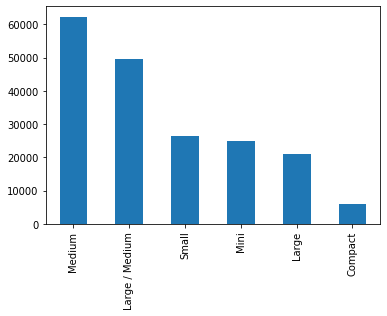

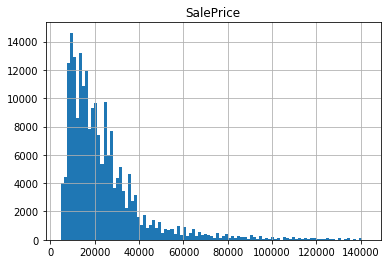

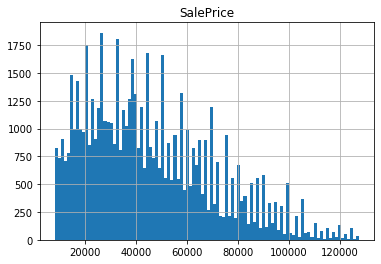

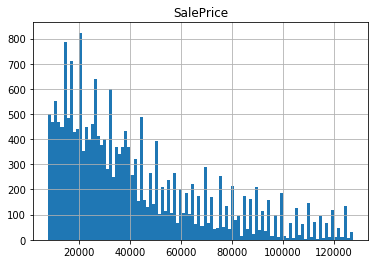

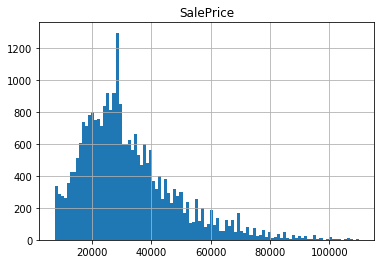

In [34]:
print('training shape',df_train.shape)
print('validation shape', df_valid.shape)
#print (df_train['Coupler_System'].unique())
print (df_train['ProductSize'].unique())

df_train['ProductSize'].value_counts().plot(kind='bar')


df_nn=df_train[df_train['ProductSize'].isnull()]
df_med=df_train[df_train['ProductSize']=='Medium']
df_large=df_train[df_train['ProductSize']=='Large']
df_small=df_train[df_train['ProductSize']=='Small']
df_lm=df_train[df_train['ProductSize']=='Large / Medium']
df_compact=df_train[df_train['ProductSize']=='Compact']


df_nn.hist(column='SalePrice',bins=100)
df_med.hist(column='SalePrice',bins=100)
df_large.hist(column='SalePrice',bins=100)
df_small.hist(column='SalePrice',bins=100)

print (df_nn.shape)

In [35]:
df_train = df_train[df_train['SalePrice'] < 110000]
print('training shape',df_train.shape)

training shape (397605, 53)


## Analysing 'Coupler_System' against 'SalePrice' to create new features (Didn't work)

32739.996814881957
26000.0
(354147, 53)
(67093, 53)
11256.263589346132
11100.0


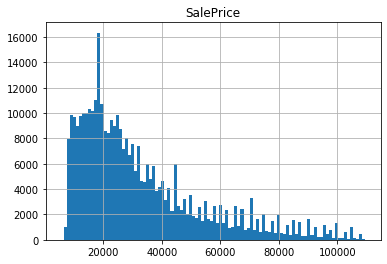

In [36]:
df_coupler=df_train[df_train['Coupler_System'].isnull()]

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)
print (df_coupler.shape)
df_coupler = df_coupler[df_coupler['SalePrice'] < 15000]
print (df_coupler.shape)
print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())

10470.911550828592
10000.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020502608088>]],
      dtype=object)

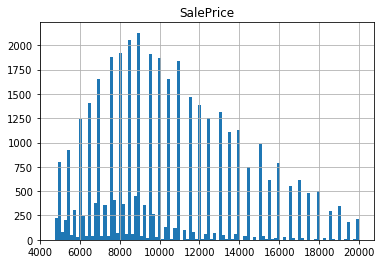

In [37]:
df_coupler=df_train[df_train['Coupler_System']=='None or Unspecified']

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)

11591.859313077939
11500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205008CC448>]],
      dtype=object)

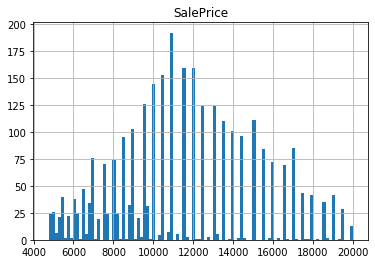

In [38]:
df_coupler=df_train[df_train['Coupler_System']=='Yes']

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)

In [39]:
#converting saleprice to log scale
y = np.log(df_train['SalePrice'])
df_train = df_train.drop('SalePrice', axis=1)

In [40]:
df_train_valid = df_train.append(df_valid)

In [41]:
df_train_valid.shape

(409178, 52)

In [42]:
# same add_datepart function as used for creating baseline model
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

        
add_datepart(df_train_valid, 'saledate')

In [43]:
df_train_valid['age'] = df_train_valid['saleYear'] - df_train_valid['YearMade'] 

In [44]:
for n,c in df_train_valid.items():
    if is_string_dtype(c): 
        #print (n)
        df_train_valid[n] = c.astype('category').cat.as_ordered()

In [45]:
#Specify order for variable UsageBand and change to codes
df_train_valid.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_train_valid.UsageBand = df_train_valid.UsageBand.cat.codes

In [46]:
#Change other categories into codes and replace NaNs with 0.
cat_cols = list(df_train_valid.select_dtypes(include=['category']).columns)  #Above UsageType is changed to Int 
for col in cat_cols:
    s = df_train_valid[col] 
    df_train_valid[col] = s.cat.codes+1


In [47]:
#Replace the NaNs for the numerical column with mean and -1 (-1 gave better results than mean/median in auctioneerID)
df_train_valid['auctioneerID'].fillna(-1, inplace=True) 
df_train_valid['MachineHoursCurrentMeter'].fillna(df_train_valid['MachineHoursCurrentMeter'].median(), inplace=True)

In [48]:
df_train_valid.isnull().sum()

SalesID                 0
MachineID               0
ModelID                 0
datasource              0
auctioneerID            0
                       ..
saleIs_quarter_start    0
saleIs_year_end         0
saleIs_year_start       0
saleElapsed             0
age                     0
Length: 65, dtype: int64

In [49]:
df_train_valid.head()
df_train_valid.shape

(409178, 65)

###  One hot encoding the ProductSize feature decreased the RMSLE score

In [50]:
#df_ps = pd.get_dummies(df_train_valid['ProductSize'], prefix = 'PS')

In [51]:
#df_ps.shape
#df_train_valid = pd.concat([df_train_valid, df_ps], axis=1)
#df_train_valid.shape

In [52]:
#df_train_valid=df_train_valid.drop(columns=['ProductSize'])


In [24]:

#labels=['age', 'ProductSize', 'fiProductClassDesc', 'ModelID', 'YearMade',
   #    'fiSecondaryDesc', 'saleElapsed', 'SalesID', 'fiBaseModel', 'Enclosure',
    #   'saleDayofyear', 'saleDay']

#df_train_valid = df_train_valid[df_important.columns]
#df_train_valid = df_train_valid[labels]
#Separate the training and validation sets
df_valid = df_train_valid.tail(11573)
df_train = df_train_valid.head(397605)

In [25]:
print (df_valid.shape)
print (df_train.shape)

(11573, 65)
(397605, 65)


### Random Forest model using all features

In [26]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_train, y) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [27]:
#Import the validation solution
solution = pd.read_csv('ValidSolution.csv', low_memory=False)
y_actual = np.log(solution.SalePrice)     

In [28]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

rmse(m.predict(df_valid), y_actual)

0.24668083100145405

In [29]:
#Use the feature importance to find the most important ones
feature_importance_valid = pd.DataFrame({'Feature' : df_train.columns, 'Importance' : m.feature_importances_})
feature_importance_valid.sort_values('Importance', ascending=False, inplace=True)
feature_importance_valid.head(30)

,Feature,Importance
64,age,0.136732
13,ProductSize,0.119302
37,Coupler_System,0.097073
14,fiProductClassDesc,0.085298
5,YearMade,0.073176
2,ModelID,0.058942
38,Grouser_Tracks,0.050028
39,Hydraulics_Flow,0.039185
10,fiSecondaryDesc,0.036134
8,fiModelDesc,0.030030


In [30]:
feature_importance_valid

,Feature,Importance
64,age,1.367316e-01
13,ProductSize,1.193015e-01
37,Coupler_System,9.707310e-02
14,fiProductClassDesc,8.529840e-02
5,YearMade,7.317593e-02
...,...,...
58,saleIs_month_start,2.266842e-04
59,saleIs_quarter_end,1.981838e-04
60,saleIs_quarter_start,1.388213e-04
61,saleIs_year_end,4.365713e-09


## Random forest using features extracted from the importance scores from baseline model

In [72]:

#labels=['age', 'ProductSize', 'fiProductClassDesc', 'ModelID', 'YearMade',
   #    'fiSecondaryDesc', 'saleElapsed', 'SalesID', 'fiBaseModel', 'Enclosure',
    #   'saleDayofyear', 'saleDay']

df_train_valid = df_train_valid[df_important.columns]
#df_train_valid = df_train_valid[labels]
#Separate the training and validation sets
df_valid = df_train_valid.tail(11573)
df_train = df_train_valid.head(397605)

In [73]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_train, y) 
print(rmse(m.predict(df_valid), y_actual))


0.2486030621721911


In [53]:
df_train_valid.shape

(409178, 65)

## Using feature importance scores from the previous model

In [54]:
for i in [0.0001, 0.0005, 0.0007, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > i]
    df_train_valid_iter = df_train_valid[important_features_valid['Feature']]
    
    df_valid = df_train_valid_iter.tail(11573)
    df_train = df_train_valid_iter.head(397605)
    
    m_iter = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
    m_iter.fit(df_train, y)
    print(rmse(m_iter.predict(df_valid), y_actual))

0.24707065922813223
0.24750963642986007
0.2473066904969417
0.24669681624944612
0.24692309875682228
0.24690487282202364
0.2487750428309561
0.24877707491625375
0.24878593626081008
0.2499025341583965
0.24996727989969864
0.2498795867960829
0.258524686359654
0.25904043903817975
0.2581712195101032
0.25880996797399997


In [57]:
# we can see best RMSLE score is for 0.0008
important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > 0.0008]

print (len(important_features_valid))
print (important_features_valid)


50
                     Feature  Importance
64                       age    0.136732
13               ProductSize    0.119302
37            Coupler_System    0.097073
14        fiProductClassDesc    0.085298
5                   YearMade    0.073176
2                    ModelID    0.058942
38            Grouser_Tracks    0.050028
39           Hydraulics_Flow    0.039185
10           fiSecondaryDesc    0.036134
8                fiModelDesc    0.030030
19                 Enclosure    0.027401
63               saleElapsed    0.026213
9                fiBaseModel    0.023604
0                    SalesID    0.021724
12         fiModelDescriptor    0.016885
17          ProductGroupDesc    0.015251
1                  MachineID    0.013372
16              ProductGroup    0.011674
30                Hydraulics    0.011020
51                  saleYear    0.008959
56             saleDayofyear    0.008352
15                     state    0.007839
18              Drive_System    0.007814
54           

In [60]:

from lightgbm import LGBMRegressor


## Using LightGBM

In [59]:
model = LGBMRegressor(
    max_depth=-1,
    boosting_type='gbdt',
    n_estimators=1500,
    min_child_weight=200, 
    colsample_bytree=0.5, 
    subsample=0.5, 
    eta=0.3,    
    seed=42)

model.fit(
    df_train, 
    y, 
    eval_metric="rmse", 
    eval_set=[(df_train, y), (df_valid, y_actual)], 
    verbose=True,    
    early_stopping_rounds = 30
    )

[1]	training's rmse: 0.636085	training's l2: 0.404604	valid_1's rmse: 0.694373	valid_1's l2: 0.482153
Training until validation scores don't improve for 30 rounds
[2]	training's rmse: 0.606089	training's l2: 0.367344	valid_1's rmse: 0.660593	valid_1's l2: 0.436384
[3]	training's rmse: 0.578188	training's l2: 0.334301	valid_1's rmse: 0.628667	valid_1's l2: 0.395222
[4]	training's rmse: 0.544312	training's l2: 0.296275	valid_1's rmse: 0.598287	valid_1's l2: 0.357947
[5]	training's rmse: 0.520053	training's l2: 0.270455	valid_1's rmse: 0.56972	valid_1's l2: 0.324581
[6]	training's rmse: 0.494879	training's l2: 0.244905	valid_1's rmse: 0.549102	valid_1's l2: 0.301513
[7]	training's rmse: 0.469769	training's l2: 0.220683	valid_1's rmse: 0.525722	valid_1's l2: 0.276384
[8]	training's rmse: 0.454125	training's l2: 0.206229	valid_1's rmse: 0.506939	valid_1's l2: 0.256987
[9]	training's rmse: 0.436343	training's l2: 0.190395	valid_1's rmse: 0.49089	valid_1's l2: 0.240973
[10]	training's rmse: 0

[80]	training's rmse: 0.251748	training's l2: 0.0633769	valid_1's rmse: 0.301439	valid_1's l2: 0.0908656
[81]	training's rmse: 0.251356	training's l2: 0.0631797	valid_1's rmse: 0.30099	valid_1's l2: 0.0905952
[82]	training's rmse: 0.250943	training's l2: 0.0629722	valid_1's rmse: 0.30066	valid_1's l2: 0.0903962
[83]	training's rmse: 0.250271	training's l2: 0.0626355	valid_1's rmse: 0.299778	valid_1's l2: 0.0898666
[84]	training's rmse: 0.249984	training's l2: 0.0624922	valid_1's rmse: 0.299596	valid_1's l2: 0.0897576
[85]	training's rmse: 0.249637	training's l2: 0.0623186	valid_1's rmse: 0.298863	valid_1's l2: 0.0893192
[86]	training's rmse: 0.249268	training's l2: 0.0621345	valid_1's rmse: 0.298286	valid_1's l2: 0.0889745
[87]	training's rmse: 0.249018	training's l2: 0.0620099	valid_1's rmse: 0.297776	valid_1's l2: 0.0886704
[88]	training's rmse: 0.248821	training's l2: 0.0619117	valid_1's rmse: 0.297697	valid_1's l2: 0.0886234
[89]	training's rmse: 0.248498	training's l2: 0.0617512	v

[159]	training's rmse: 0.233732	training's l2: 0.0546305	valid_1's rmse: 0.277591	valid_1's l2: 0.0770569
[160]	training's rmse: 0.233623	training's l2: 0.0545795	valid_1's rmse: 0.277421	valid_1's l2: 0.0769625
[161]	training's rmse: 0.233438	training's l2: 0.0544935	valid_1's rmse: 0.277322	valid_1's l2: 0.0769073
[162]	training's rmse: 0.233297	training's l2: 0.0544276	valid_1's rmse: 0.277106	valid_1's l2: 0.0767875
[163]	training's rmse: 0.233169	training's l2: 0.0543676	valid_1's rmse: 0.277034	valid_1's l2: 0.0767477
[164]	training's rmse: 0.232938	training's l2: 0.0542599	valid_1's rmse: 0.276766	valid_1's l2: 0.0765993
[165]	training's rmse: 0.232797	training's l2: 0.0541946	valid_1's rmse: 0.276552	valid_1's l2: 0.0764811
[166]	training's rmse: 0.232657	training's l2: 0.0541292	valid_1's rmse: 0.276313	valid_1's l2: 0.0763489
[167]	training's rmse: 0.23252	training's l2: 0.0540655	valid_1's rmse: 0.276217	valid_1's l2: 0.0762957
[168]	training's rmse: 0.232392	training's l2: 

[238]	training's rmse: 0.225351	training's l2: 0.0507833	valid_1's rmse: 0.267235	valid_1's l2: 0.0714147
[239]	training's rmse: 0.225285	training's l2: 0.0507533	valid_1's rmse: 0.267208	valid_1's l2: 0.0714003
[240]	training's rmse: 0.225221	training's l2: 0.0507247	valid_1's rmse: 0.267151	valid_1's l2: 0.0713696
[241]	training's rmse: 0.22516	training's l2: 0.0506969	valid_1's rmse: 0.267088	valid_1's l2: 0.0713359
[242]	training's rmse: 0.22505	training's l2: 0.0506477	valid_1's rmse: 0.26692	valid_1's l2: 0.0712465
[243]	training's rmse: 0.224954	training's l2: 0.0506043	valid_1's rmse: 0.266761	valid_1's l2: 0.0711616
[244]	training's rmse: 0.224889	training's l2: 0.050575	valid_1's rmse: 0.266731	valid_1's l2: 0.0711454
[245]	training's rmse: 0.224825	training's l2: 0.0505462	valid_1's rmse: 0.266725	valid_1's l2: 0.071142
[246]	training's rmse: 0.224705	training's l2: 0.0504921	valid_1's rmse: 0.266505	valid_1's l2: 0.0710251
[247]	training's rmse: 0.224626	training's l2: 0.05

[319]	training's rmse: 0.220127	training's l2: 0.0484559	valid_1's rmse: 0.261055	valid_1's l2: 0.0681495
[320]	training's rmse: 0.220077	training's l2: 0.048434	valid_1's rmse: 0.261015	valid_1's l2: 0.0681287
[321]	training's rmse: 0.220049	training's l2: 0.0484215	valid_1's rmse: 0.261024	valid_1's l2: 0.0681335
[322]	training's rmse: 0.219989	training's l2: 0.048395	valid_1's rmse: 0.261021	valid_1's l2: 0.0681319
[323]	training's rmse: 0.219929	training's l2: 0.0483687	valid_1's rmse: 0.260957	valid_1's l2: 0.0680984
[324]	training's rmse: 0.219885	training's l2: 0.0483493	valid_1's rmse: 0.260902	valid_1's l2: 0.0680696
[325]	training's rmse: 0.219817	training's l2: 0.0483197	valid_1's rmse: 0.260751	valid_1's l2: 0.0679909
[326]	training's rmse: 0.219776	training's l2: 0.0483015	valid_1's rmse: 0.260742	valid_1's l2: 0.0679862
[327]	training's rmse: 0.219729	training's l2: 0.0482807	valid_1's rmse: 0.260769	valid_1's l2: 0.0680003
[328]	training's rmse: 0.219681	training's l2: 0

[399]	training's rmse: 0.216316	training's l2: 0.0467928	valid_1's rmse: 0.257025	valid_1's l2: 0.066062
[400]	training's rmse: 0.216274	training's l2: 0.0467745	valid_1's rmse: 0.256956	valid_1's l2: 0.0660263
[401]	training's rmse: 0.216209	training's l2: 0.0467465	valid_1's rmse: 0.25691	valid_1's l2: 0.0660026
[402]	training's rmse: 0.216145	training's l2: 0.0467187	valid_1's rmse: 0.256796	valid_1's l2: 0.0659441
[403]	training's rmse: 0.216089	training's l2: 0.0466943	valid_1's rmse: 0.256746	valid_1's l2: 0.0659184
[404]	training's rmse: 0.216075	training's l2: 0.0466883	valid_1's rmse: 0.256735	valid_1's l2: 0.0659128
[405]	training's rmse: 0.216035	training's l2: 0.046671	valid_1's rmse: 0.256728	valid_1's l2: 0.065909
[406]	training's rmse: 0.215992	training's l2: 0.0466527	valid_1's rmse: 0.256698	valid_1's l2: 0.065894
[407]	training's rmse: 0.215949	training's l2: 0.046634	valid_1's rmse: 0.256689	valid_1's l2: 0.0658894
[408]	training's rmse: 0.215926	training's l2: 0.046

[477]	training's rmse: 0.213337	training's l2: 0.0455128	valid_1's rmse: 0.254215	valid_1's l2: 0.0646254
[478]	training's rmse: 0.213294	training's l2: 0.0454945	valid_1's rmse: 0.254163	valid_1's l2: 0.0645988
[479]	training's rmse: 0.213262	training's l2: 0.0454807	valid_1's rmse: 0.254144	valid_1's l2: 0.0645891
[480]	training's rmse: 0.213228	training's l2: 0.0454661	valid_1's rmse: 0.254115	valid_1's l2: 0.0645745
[481]	training's rmse: 0.213182	training's l2: 0.0454465	valid_1's rmse: 0.254081	valid_1's l2: 0.064557
[482]	training's rmse: 0.213151	training's l2: 0.0454333	valid_1's rmse: 0.254084	valid_1's l2: 0.0645586
[483]	training's rmse: 0.213105	training's l2: 0.0454136	valid_1's rmse: 0.254084	valid_1's l2: 0.0645587
[484]	training's rmse: 0.213079	training's l2: 0.0454027	valid_1's rmse: 0.254061	valid_1's l2: 0.064547
[485]	training's rmse: 0.213051	training's l2: 0.0453905	valid_1's rmse: 0.254055	valid_1's l2: 0.064544
[486]	training's rmse: 0.213016	training's l2: 0.

[558]	training's rmse: 0.210815	training's l2: 0.044443	valid_1's rmse: 0.251704	valid_1's l2: 0.063355
[559]	training's rmse: 0.210794	training's l2: 0.0444339	valid_1's rmse: 0.251694	valid_1's l2: 0.0633501
[560]	training's rmse: 0.21076	training's l2: 0.0444196	valid_1's rmse: 0.25169	valid_1's l2: 0.0633478
[561]	training's rmse: 0.210737	training's l2: 0.0444099	valid_1's rmse: 0.251689	valid_1's l2: 0.0633473
[562]	training's rmse: 0.210711	training's l2: 0.0443991	valid_1's rmse: 0.251586	valid_1's l2: 0.0632956
[563]	training's rmse: 0.210683	training's l2: 0.0443875	valid_1's rmse: 0.25158	valid_1's l2: 0.0632923
[564]	training's rmse: 0.210654	training's l2: 0.0443752	valid_1's rmse: 0.25156	valid_1's l2: 0.0632822
[565]	training's rmse: 0.210619	training's l2: 0.0443603	valid_1's rmse: 0.251544	valid_1's l2: 0.0632743
[566]	training's rmse: 0.210592	training's l2: 0.0443489	valid_1's rmse: 0.251532	valid_1's l2: 0.0632685
[567]	training's rmse: 0.210555	training's l2: 0.044

[637]	training's rmse: 0.208655	training's l2: 0.043537	valid_1's rmse: 0.250325	valid_1's l2: 0.0626625
[638]	training's rmse: 0.208633	training's l2: 0.0435276	valid_1's rmse: 0.250329	valid_1's l2: 0.0626647
[639]	training's rmse: 0.2086	training's l2: 0.0435141	valid_1's rmse: 0.250326	valid_1's l2: 0.0626629
[640]	training's rmse: 0.208588	training's l2: 0.0435089	valid_1's rmse: 0.250324	valid_1's l2: 0.0626622
[641]	training's rmse: 0.208564	training's l2: 0.0434988	valid_1's rmse: 0.250313	valid_1's l2: 0.0626565
[642]	training's rmse: 0.208506	training's l2: 0.0434748	valid_1's rmse: 0.250332	valid_1's l2: 0.062666
[643]	training's rmse: 0.208484	training's l2: 0.0434657	valid_1's rmse: 0.25032	valid_1's l2: 0.06266
[644]	training's rmse: 0.208469	training's l2: 0.0434592	valid_1's rmse: 0.2503	valid_1's l2: 0.06265
[645]	training's rmse: 0.208442	training's l2: 0.0434479	valid_1's rmse: 0.250302	valid_1's l2: 0.0626512
[646]	training's rmse: 0.208425	training's l2: 0.0434409	

[717]	training's rmse: 0.206566	training's l2: 0.0426696	valid_1's rmse: 0.249362	valid_1's l2: 0.0621813
[718]	training's rmse: 0.206531	training's l2: 0.0426551	valid_1's rmse: 0.249359	valid_1's l2: 0.0621797
[719]	training's rmse: 0.206517	training's l2: 0.0426495	valid_1's rmse: 0.249359	valid_1's l2: 0.0621802
[720]	training's rmse: 0.206505	training's l2: 0.0426444	valid_1's rmse: 0.249358	valid_1's l2: 0.0621793
[721]	training's rmse: 0.206477	training's l2: 0.0426329	valid_1's rmse: 0.249339	valid_1's l2: 0.0621701
[722]	training's rmse: 0.206468	training's l2: 0.042629	valid_1's rmse: 0.249335	valid_1's l2: 0.0621681
[723]	training's rmse: 0.206451	training's l2: 0.042622	valid_1's rmse: 0.249312	valid_1's l2: 0.0621566
[724]	training's rmse: 0.206425	training's l2: 0.0426111	valid_1's rmse: 0.249284	valid_1's l2: 0.0621424
[725]	training's rmse: 0.206396	training's l2: 0.0425995	valid_1's rmse: 0.249279	valid_1's l2: 0.06214
[726]	training's rmse: 0.206375	training's l2: 0.0

[796]	training's rmse: 0.204826	training's l2: 0.0419536	valid_1's rmse: 0.247824	valid_1's l2: 0.0614166
[797]	training's rmse: 0.204808	training's l2: 0.0419464	valid_1's rmse: 0.247761	valid_1's l2: 0.0613857
[798]	training's rmse: 0.204793	training's l2: 0.0419402	valid_1's rmse: 0.247765	valid_1's l2: 0.0613876
[799]	training's rmse: 0.204761	training's l2: 0.0419271	valid_1's rmse: 0.247715	valid_1's l2: 0.0613626
[800]	training's rmse: 0.204747	training's l2: 0.0419212	valid_1's rmse: 0.2477	valid_1's l2: 0.0613552
[801]	training's rmse: 0.204726	training's l2: 0.0419128	valid_1's rmse: 0.247684	valid_1's l2: 0.0613474
[802]	training's rmse: 0.204702	training's l2: 0.0419027	valid_1's rmse: 0.247627	valid_1's l2: 0.0613192
[803]	training's rmse: 0.204675	training's l2: 0.0418921	valid_1's rmse: 0.247607	valid_1's l2: 0.0613095
[804]	training's rmse: 0.204656	training's l2: 0.0418839	valid_1's rmse: 0.247642	valid_1's l2: 0.0613267
[805]	training's rmse: 0.204644	training's l2: 0

[875]	training's rmse: 0.203302	training's l2: 0.0413316	valid_1's rmse: 0.246984	valid_1's l2: 0.061001
[876]	training's rmse: 0.203282	training's l2: 0.0413238	valid_1's rmse: 0.24699	valid_1's l2: 0.0610041
[877]	training's rmse: 0.20327	training's l2: 0.0413186	valid_1's rmse: 0.246988	valid_1's l2: 0.061003
[878]	training's rmse: 0.203253	training's l2: 0.0413118	valid_1's rmse: 0.246981	valid_1's l2: 0.0609994
[879]	training's rmse: 0.203237	training's l2: 0.0413054	valid_1's rmse: 0.246968	valid_1's l2: 0.0609932
[880]	training's rmse: 0.203222	training's l2: 0.0412993	valid_1's rmse: 0.246965	valid_1's l2: 0.0609919
[881]	training's rmse: 0.203194	training's l2: 0.0412877	valid_1's rmse: 0.246957	valid_1's l2: 0.0609879
[882]	training's rmse: 0.203178	training's l2: 0.0412814	valid_1's rmse: 0.246962	valid_1's l2: 0.0609901
[883]	training's rmse: 0.203161	training's l2: 0.0412745	valid_1's rmse: 0.246921	valid_1's l2: 0.0609698
[884]	training's rmse: 0.203146	training's l2: 0.0

[954]	training's rmse: 0.201902	training's l2: 0.0407644	valid_1's rmse: 0.246877	valid_1's l2: 0.0609481
[955]	training's rmse: 0.201878	training's l2: 0.0407546	valid_1's rmse: 0.246853	valid_1's l2: 0.0609362
[956]	training's rmse: 0.201849	training's l2: 0.0407429	valid_1's rmse: 0.246854	valid_1's l2: 0.0609368
[957]	training's rmse: 0.201819	training's l2: 0.0407309	valid_1's rmse: 0.246766	valid_1's l2: 0.0608935
[958]	training's rmse: 0.201794	training's l2: 0.0407207	valid_1's rmse: 0.246704	valid_1's l2: 0.0608629
[959]	training's rmse: 0.201774	training's l2: 0.0407127	valid_1's rmse: 0.246705	valid_1's l2: 0.0608635
[960]	training's rmse: 0.201753	training's l2: 0.0407042	valid_1's rmse: 0.246712	valid_1's l2: 0.0608669
[961]	training's rmse: 0.20174	training's l2: 0.0406989	valid_1's rmse: 0.246713	valid_1's l2: 0.0608673
[962]	training's rmse: 0.201729	training's l2: 0.0406947	valid_1's rmse: 0.246713	valid_1's l2: 0.0608671
[963]	training's rmse: 0.201716	training's l2: 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              eta=0.3, importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=200, min_split_gain=0.0,
              n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
              silent=True, subsample=0.5, subsample_for_bin=200000,
              subsample_freq=0)

## Future Improvements

    (1) Use clustering/dendograms based techniques for feature extraction 
    (2) Hyperparameter tuning in LGBM and XGBoost regressors
    (3) Selecting and clubbing two or more features
    (4) Use binning for relevant feature
    (5) Try to make more hand features
    (6) Impute the nan missing values with some other values than mean or median